# Quantum Computing

## 4. Control

**Frank C Langbein**

$\def\ket#1{|#1\rangle} \def\bra#1{\langle#1|}$

# Quantum Control

* Find optimal fields $u_k(t)$ to steer the dynamics of a quantum system
  $$i\hbar \frac{\partial\ket{\psi}}{\partial t} = \underbrace{\left( H_0 + \sum_k u_k(t)H_k \right)}_{=H}\ket{\Psi}$$

* By maximising a fidelity function to implement a unitary operator (gate) $U_t$
  $$f(u_1,\dots,u_n) = \frac{1}{N} \left|\text{tr}\left(U_t^\dagger e^{-i/\hbar H t_f}\right)\right|$$
* Typically $u_k(t)$ are piecewise constant over $\Delta t$ time intervals
  $$U_k = \text{expm}(-i/\hbar H(u_1(t_k),\dots,u_n(t_k)) \overbrace{(t_{k}-t_{k-1})}^{=\Delta t})$$
  $$U = U_n U_{n-1} \cdots U_1, \ket{\psi(t_n)} = U \ket{\psi(0)}$$
  
* Can change optimisation target (fidelity of creating a state, maximise an observable)
* Can add target time $t_f$ to optimisation parameters
* Can extend to optimise against decoherence effects or even use decoherence to control the system

# Spin-1/2 Networks

![Spin network](snet.png)

* System Hammiltonian
  $$H_0 = \sum_{k,l} J^X_{k,l} \sigma^x_k\sigma^x_l + J^Y_{k,l} \sigma^y_k\sigma^y_l + J^Z_{k,l} \sigma^z_k\sigma^z_l + \sum_k J_k\sigma^z_k$$
  * where
    $$\sigma^x_k = I \otimes \cdots \otimes I \otimes X \otimes I \otimes \cdots \otimes I$$
    and similar for $y$ and $z$ are the Pauli operators on spin $k$ (where $X$/$Y$/$Z$ is at position $k$ in the tensor product)

* Control Hamiltonians can be on the couplings or the local potentials


In [1]:
# Simple control example with qutip

import matplotlib.pyplot as plt
import time
import numpy as np

from qutip import *
from qutip.qip.operations import *
from qutip.control import *

# System Hamiltonian
H0 = tensor(sigmax(), identity(2)) + tensor(identity(2), sigmax())

# Target
U = cnot()

# Target time and time intervals
T = 2 * np.pi 
times = np.linspace(0, T, 500)

In [2]:
# Control Hamiltonians
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]
H_labels = [r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
            r'$u_{2x}$', r'$u_{2y}$', r'$u_{2z}$',
            r'$u_{h}$' ]

In [3]:
from qutip.control.grape import plot_grape_control_fields, cy_grape_unitary
from qutip.ui.progressbar import TextProgressBar

# Initial value (random)
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

# Limits for controls
u_limits = None #[0, 1 * 2 * pi]

# Penalty for high-energy controls
alpha = None

# Maximum iterations
max_iter = 500

In [4]:
result = cy_grape_unitary(U, H0, H_ops, max_iter, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time: 162.08s. Est. time left: 00:00:24:18
20.0%. Run time: 325.26s. Est. time left: 00:00:21:41
30.0%. Run time: 485.88s. Est. time left: 00:00:18:53
40.0%. Run time: 649.18s. Est. time left: 00:00:16:13
50.0%. Run time: 813.38s. Est. time left: 00:00:13:33
60.0%. Run time: 976.52s. Est. time left: 00:00:10:51
70.0%. Run time: 1136.93s. Est. time left: 00:00:08:07
80.0%. Run time: 1296.11s. Est. time left: 00:00:05:24
90.0%. Run time: 1455.10s. Est. time left: 00:00:02:41
Total run time: 1611.82s


Fidelity =  1.0000000000000004
[[-7.07106781e-01-7.07106781e-01j  1.38289207e-11-1.13443299e-11j
   1.88993089e-11+4.60336322e-11j -4.37084100e-11-2.19102328e-11j]
 [ 1.13438700e-11-1.38304961e-11j -7.07106781e-01-7.07106781e-01j
   1.61405993e-11+3.01223855e-11j -2.85033514e-11-1.91840351e-11j]
 [ 2.19097442e-11+4.37076566e-11j  1.91844779e-11+2.85018406e-11j
   9.76845514e-12+1.33050862e-12j -7.07106781e-01-7.07106781e-01j]
 [-4.60348545e-11-1.88981354e-11j -3.01254750e-11-1.61405438e-11j
  -7.07106781e-01-7.07106781e-01j -1.33247233e-12-9.76608551e-12j]]


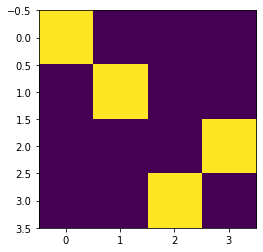

In [5]:
print ('Fidelity = ', np.abs((U.dag() * result.U_f).tr()) / 4)
print(result.U_f.full())
plt.imshow(np.abs(result.U_f.full()))

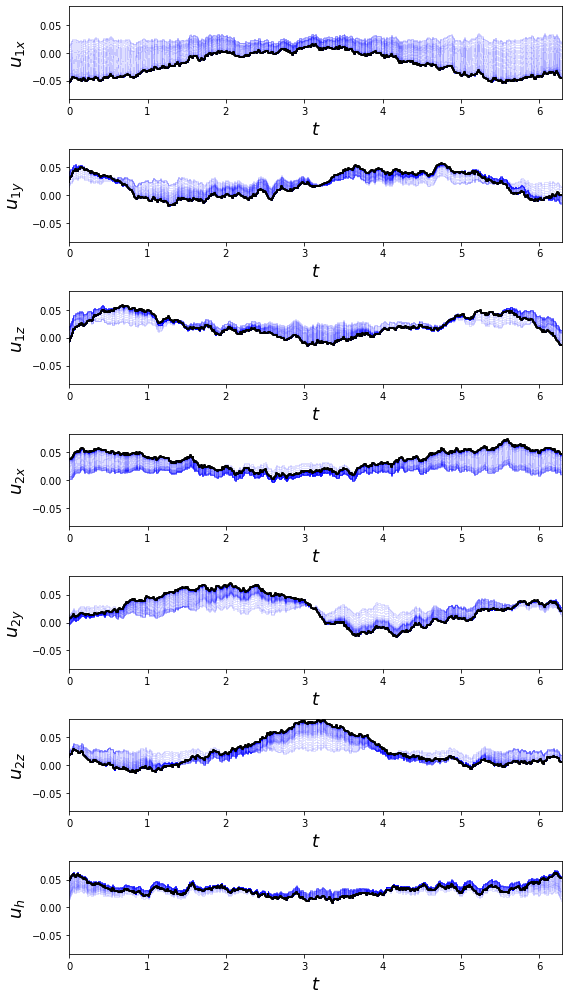

In [6]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);